## **Tv-Show-Pages-Network-Analysis**

#### `Name & Surname: Abdulkadir Arslan`

## **The Packages:**

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
from edge_split import EdgeSplitter #It is imported from the edge_split.py file in the experiments zip folder
from sklearn.model_selection import train_test_split
import multiprocessing
from stellargraph.data import BiasedRandomWalk
from gensim.models import Word2Vec
from stellargraph import StellarGraph
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegressionCV
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier

## **1. TASK 1 - STORY**

<div class="alert alert-block alert-info">

**A Fictitious Situation:**

I imagined that I work as a data scientist for a streaming platform called Streamify, which provides a wide range of TV shows to its subscribers. Streamify is constantly looking to improve user engagement and retention by recommending relevant content to its users because they noticed a decline in user engagement, they have been facing challenges with user retention and engagement due to the limitations of its existing recommendation system. 

**The Project:**

Users are not discovering new content that aligns with their interests, leading to dissatisfaction and churn. Traditional methods like collaborative filtering and content-based filtering are not yielding satisfactory results anymore. Therefore, the organization has tasked me with developing a more advanced recommendation system. To address this issue, Streamify decides to explore alternative approaches for content recommendation.

**The Plan of the Experiment:**

As a data scientist, I propose leveraging the rich data available on Facebook, where TV show pages interact with each other through likes. This data presents a valuable opportunity to uncover hidden relationships between TV shows that may not be apparent from traditional metadata. I suggested an approach which is developing a more advanced recommendation system that leverages the underlying relationships between TV shows based on their Facebook interactions.

My experiment involves constructing a graph representation of the Facebook network and analyzing it. Using advanced graph analysis techniques and machine learning algorithms, I aim to predict potential connections (edges) between TV shows that have not yet interacted on Facebook.

**The Purpose (Expected Value):**

If successful, this graph analysis will enable Streamify to enhance its recommendation system significantly. By recommending not only similar shows but also those with underlying connections based on their Facebook interactions, Streamify can offer users a more diverse and personalized viewing experience. This, in turn, is expected to increase user engagement, satisfaction, and ultimately, retention on the platform.

In conclusion, the experiment aims to leverage graph analysis of the Facebook network to revolutionize content recommendation on Streamify, ultimately driving value by enhancing user experience and improving business outcomes.

## **2. TASK 2 - The DATA**

***The Data Availability:*** 

I obtained the data from [Network Repository](https://networkrepository.com/index.php), an interactive data and network data repository with real-time visual analytics. 

[Click to access the web page where the data is provided](https://networkrepository.com/fb-pages-tvshow.php). For the license click [here.](https://networkrepository.com/policy.php)

*The Source (Citation):* Ryan A. Rossi and Nesreen K. Ahmed, [The Network Data Repository with Interactive Graph Analytics and Visualization](https://networkrepository.com). AAAI, 2015.


In [3]:
df_nodes = pd.read_csv('fb-pages-tvshow.nodes')
df_nodes

,id,name,new_id
0,183215455178728,Orange is the New Black,1852
1,282808121926963,狮城有约 Hello Singapore,592
2,179653538737148,DC Cupcakes,1370
3,162816367111296,Gladiatorerna,1263
4,134115896703387,Globo Rural,3042
...,...,...,...
3876,158905497594929,The Fosters,1400
3877,543790868991966,O Negócio - HBO,1846
3878,161199750538,Take Me Out,3571
3879,1557355931216595,ExtraOrdinários - Sportv,1239


In [4]:
df_edges = pd.read_csv('fb-pages-tvshow.edges', names=['node_1', 'node_2'])
df_edges

,node_1,node_2
0,0,1838
1,0,1744
2,0,14
3,0,2543
4,1,1009
...,...,...
17257,3826,3844
17258,3830,3843
17259,1240,1240
17260,3876,3885


***The Dataset Explanation:*** 

The data is a combination of two datasets: the metadata containing unique IDs and names for each TV show page, and the main dataset consisting of pairs of TV show pages liking each other's pages.
- In the main dataset, a node represents a Facebook page of a TV show, and an edge represents mutual liking between two TV show pages which makes it undirected.
    - Each Facebook page is represented by a unique numeric ID.
- The metadata provides information about each node, so the name of the Facebook pages.

    `id - (numeric)`: unique Facebook identifier

    `name`: name of the TV show's Facebook page
    
    `new_id - (numeric)`: unique identifier representing a node
    

***How the dataset is suitable for the project from Task 1:***

Across the globe, Facebook stands out as one of the most widely used social media platforms. The number of likes on TV show pages serves as a genuine indicator of their real-world popularity. TV show pages that are likely to like each other in the future, indicating a probable overlap in similarity.


## **3. TASK 3 - IDA**

In [5]:
df = df_edges.copy()
df.head()

,node_1,node_2
0,0,1838
1,0,1744
2,0,14
3,0,2543
4,1,1009


In [6]:
print("Shape of the DataFrame (number of rows, number of columns):", df.shape)

print("\nInformation about the DataFrame:\n")
df.info()

print("\nNumber of missing values in each column:\n")
print(df.isna().sum())


Shape of the DataFrame (number of rows, number of columns): (17262, 2)

Information about the DataFrame:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17262 entries, 0 to 17261
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   node_1  17262 non-null  int64
 1   node_2  17262 non-null  int64
dtypes: int64(2)
memory usage: 269.8 KB

Number of missing values in each column:

node_1    0
node_2    0
dtype: int64


In [7]:
duplicate_rows = df[df.duplicated()]
if not duplicate_rows.empty:
    df = df.drop_duplicates(keep='first')
    print("Duplicates have been removed.")
else:
    print("No duplicates found in the DataFrame.")

No duplicates found in the DataFrame.


In [8]:
node_1_TVshows = df['node_1'].unique()
node_2_TVshows = df['node_2'].unique()

all_TVshows = set(node_1_TVshows).union(node_2_TVshows)
print('The number of the unique TV shows presented in the network: {}'.format(len(all_TVshows)))

The number of the unique TV shows presented in the network: 3892


In [9]:
new_ids_list= df_nodes['new_id'].tolist()
unique_ids = set(new_ids_list)
no_name_TVshows = [item for item in unique_ids.union(all_TVshows) if item not in unique_ids.intersection(all_TVshows)]
print('The TV shows that do not have a metadata(a name):\n')
no_name_TVshows

The TV shows that do not have a metadata(a name):



[657, 879, 1385, 1558, 1674, 1811, 2336, 3699, 3781, 3805, 3820]

In the code cell below, I replaced the numeric node IDs with the actual names of the nodes to make future analyses and processes more descriptive.

In [10]:
df = df_edges.copy()

for id in all_TVshows:
    node_names = df_nodes[df_nodes['new_id']==id]['name'].values
    if len(node_names)>0:
        node_name = node_names[0]
        df = df.replace({id:node_name})

df.head()

,node_1,node_2
0,Dancing With The Stars. Taniec z Gwiazdami,Twoja twarz brzmi znajomo
1,Dancing With The Stars. Taniec z Gwiazdami,Hell's Kitchen Polska
2,Dancing With The Stars. Taniec z Gwiazdami,Pierwsza miłość
3,Dancing With The Stars. Taniec z Gwiazdami,TOP CHEF Polska
4,Chris Jansing,Morning Joe


***Top 20 Most Frequent(Liked) TV Shows in the Dataset:***

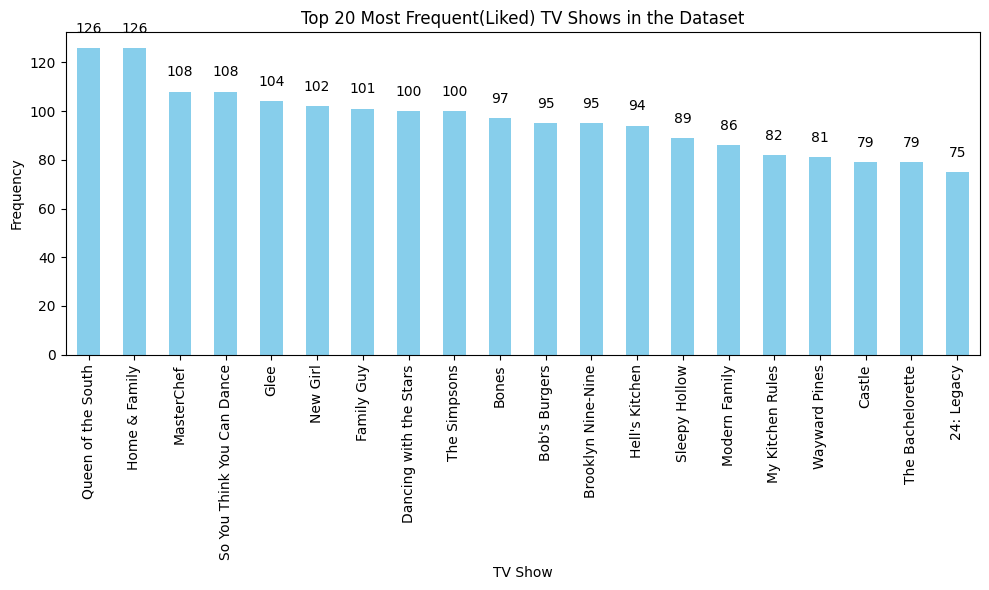

In [11]:
tv_show_counts = pd.concat([df['node_1'], df['node_2']]).value_counts()

plt.figure(figsize=(10, 6))
tv_show_counts_top20 = tv_show_counts.head(20)
tv_show_counts_top20.plot(kind='bar', color='skyblue')
plt.title('Top 20 Most Frequent(Liked) TV Shows in the Dataset')
plt.xlabel('TV Show')
plt.ylabel('Frequency')
plt.xticks(rotation=90)

for i, count in enumerate(tv_show_counts_top20):
    plt.text(i, count + 5, str(count), ha='center', va='bottom')

plt.tight_layout()
plt.show()

Comments for the initial data analysis:
- The number of rows and columns, concise summary of the dataset are presented to got an overview about the dataset.
- There is not any missing values in any column and there is not a duplication in the dataset.
- There are 3892 unique TV show Facebook pages in the dataset and 11 of them's name are not known.
- The top 20 most fruquent(liked) Facebook pages of the TV shows are visualized with the number of likes that they have. These TV show Facebook pages exhibit a significant degree of popularity, potentially serving as pivotal nodes within the network.

## **4. TASK 4 - GRAPH PROPERTIES**

In the code cell below, I brought the dataset into the form(a graph) that I need for the experiments and displayed the graph.

A wire mesh of TV shows' Facebook pages (blue dots), the black lines are the links or edges connecting all the nodes to each other.


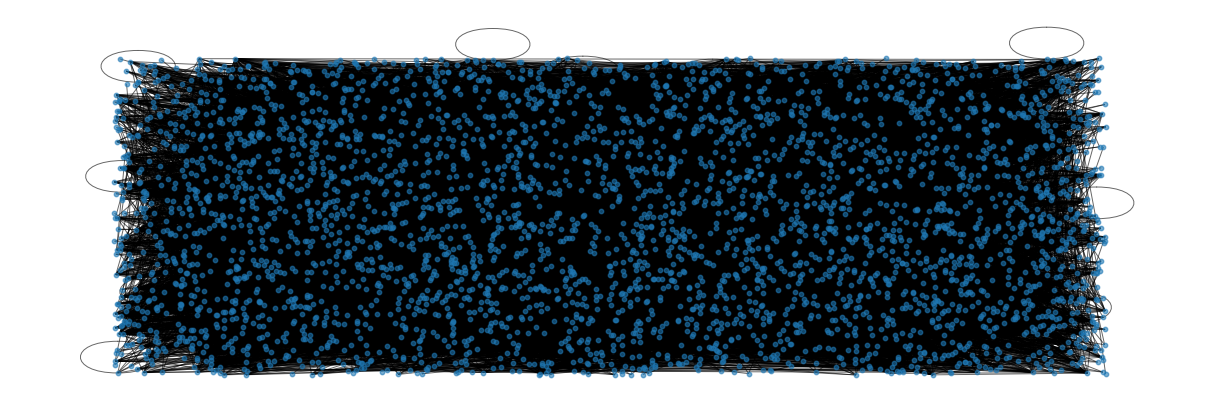

In [11]:
G = nx.from_pandas_edgelist(df= df, source="node_1", target="node_2", create_using=nx.Graph())

plt.figure(figsize=(12,4))

pos = nx.random_layout(G, seed=23)
nx.draw(G, with_labels=False,  pos = pos, node_size = 10, alpha = 0.6, width = 0.7)
print("A wire mesh of TV shows' Facebook pages (blue dots), the black lines are the links or edges connecting all the nodes to each other.")
plt.show()

In the code cell below, I visualized the distrubition of nodes' degrees in the graph.

The distribution of nodes' degrees corresponds to the percentile values as follows (Q1, Q2, Q3) = [ 2  5 10]


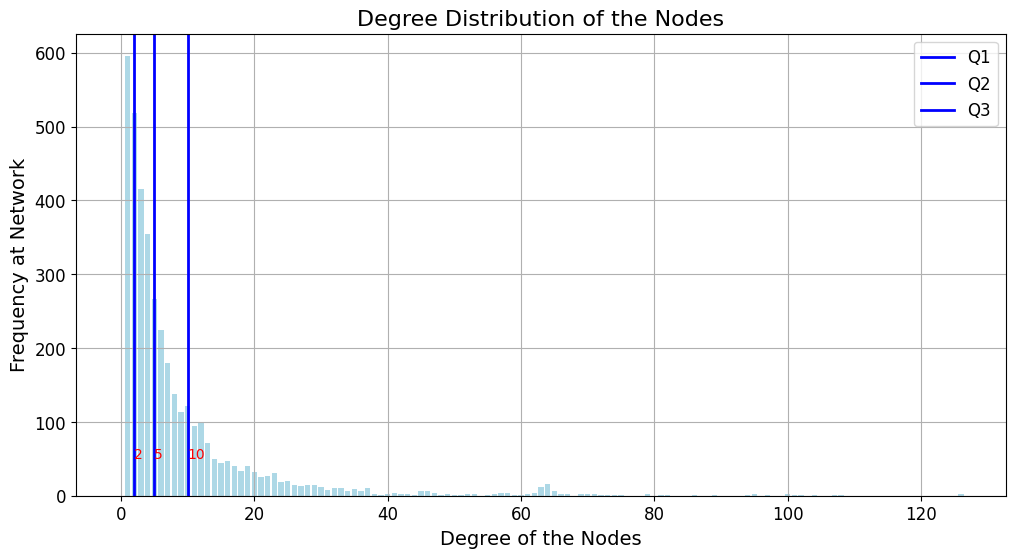

In [12]:
node_degrees = dict(G.degree())
node_degree_values = list(node_degrees.values())

node_degree_hist = nx.degree_histogram(G)

percentile = np.percentile(node_degree_values, [25, 50, 75]).astype(int)

plt.figure(figsize=(12, 6))
plt.title('Degree Distribution of the Nodes', fontsize=16)
plt.xlabel('Degree of the Nodes', fontsize=14)
plt.ylabel('Frequency at Network', fontsize=14)
bars = plt.bar(range(len(node_degree_hist)), node_degree_hist, width=0.8, color='lightblue')
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.grid(True)

for q in percentile:
    plt.axvline(q, color='b', linestyle='-', linewidth=2, label=f'Q{int((percentile.tolist().index(q) + 1))}')
    plt.text(q, 50, f'{q}', color='red', fontsize=10)

plt.legend(fontsize=12)  

print("The distribution of nodes' degrees corresponds to the percentile values as follows (Q1, Q2, Q3) = {}" .format(percentile))

plt.show()


- 25% of the nodes(TV show Facebook pages) have mutual-likes less than 2, 50%  of the nodes have mutual-likes less than 5 and 75% of the nodes have mutual-likes less than 10.
- There are very few pages that have high degree/mutual-likes, these must be the most liked TV shows' pages.
- The degree distribution displayed above indicates a right-skewed distribution, with a majority of values concentrated on the left side of the graph. This skewness suggests that there are relatively few nodes with high degrees, while the majority of nodes have lower degrees. This type of distribution is typical in many real-world networks, where a few nodes have a disproportionately large number of connections, while most nodes have only a few connections.
----------------------------------------------------------------------------------------------------------------------------------------------------------

I performed and demonstrated the graph properties in the following steps of Task 4 after bringing the dataset into the form I needed and exploring some of the basics of the graph.

Various Graph Properties:

 `num_of_nodes` , `num_of_edges` , ` density` , `connectiveness` , `average_shortest_path_length ` , `transitivity(clustering coefficient)` ,`assortativity`

 -----------------------------------------------------------------------------------------------------------------------------------------------------------

In the following code cell, I first created a dictionary to store all properties at one place and then added `num_of_nodes` and `num_of_edges` to the properties dictionary.

In [13]:
graph_properties_dict = dict()

graph_properties_dict['num_of_nodes'] = len(G.nodes())
graph_properties_dict['num_of_edges'] = len(G.edges())

display(len(G.nodes()))
display(len(G.edges()))

3863

17254

- "num_of_nodes" represents the number (3863) of the nodes in the network.

- "num_of_edges" represents the number (17254) of the edges in the network.

Therefore, there are 3863 TV shows' Facebook pages and 17254 mutual likes between them.

In the following code cell, I computed the `density` of the network and then added it to the properties dictionary.

In [14]:
network_density = nx.density(G)
display(network_density )

graph_properties_dict['density'] = network_density 

0.00231303823484108

- Density measures the proportion of possible edges in the graph that are actually present. In this case, the density of 0.002313 indicates that approximately 0.23% of all possible connections between TV show pages are realized in the Facebook network.
- While the density is relatively low, it signifies that the network is not overly sparse, meaning there are still substantial connections between TV show pages. This ensures that there is enough information available for analysis to make meaningful predictions about potential connections between shows.

In the following code cell, I checked the `connectiveness` of the network and then added it to the properties dictionary.

In [15]:
connected = nx.is_connected(G)
display(connected)

graph_properties_dict['connected'] = connected

True

- A connected graph means that there exists a path between every pair of nodes in the network. In this case, it indicates that all TV show pages are related to one another through some sequence of connections.

- The fact that the graph is connected ensures that there are pathways for information flow between all TV show pages. This is crucial for a recommendation system, as it ensures that no shows are isolated, and recommendations can be made across the entire network.

In the following code cell, I computed the `average_shortest_path_length ` of the network and then added it to the properties dictionary.

In [16]:
ave_shortest_path = nx.average_shortest_path_length(G)
display(ave_shortest_path)

graph_properties_dict['ave_shortest_path_length'] = ave_shortest_path

6.171881637969969

- The average shortest path length is the average number of steps required to navigate from one TV show page to another, considering the shortest paths between all pairs of nodes.
- The relatively low average shortest path length of 6.171882 indicates that, on average, TV show pages are not too distant from each other within the network. This compactness facilitates efficient navigation and information flow between shows, enabling the recommendation system to discover related content more effective

In the following code cell, I computed the `transitivity(clustering coefficient)` of the network and then added it to the properties dictionary.

In [17]:
transitivity = nx.transitivity(G)
display(transitivity)

graph_properties_dict['transitivity'] = transitivity

0.5862366739413732

- Transitivity measures the tendency of nodes to form clusters or triangles in the network. It reflects how tightly knit the network is.
- The high clustering coefficient of 0.586237 indicates that TV show pages tend to form clusters or groups with other related shows. This clustering behavior is advantageous for the recommendation system, as it helps in identifying similar groups of shows. Recommendations can be tailored within these clusters, ensuring that users are presented with content that aligns closely with their interests.

In the following code cell, I computed the `assortativity` of the network and then added it to the properties dictionary. I also converted the final properties dictionary to a pandas dataframe and displayed it.

In [18]:
assortativity = nx.degree_assortativity_coefficient(G)
display(assortativity)

graph_properties_dict['assortativity'] = assortativity

df_properties = pd.DataFrame()
df_properties = pd.DataFrame(graph_properties_dict, index=['graph_properties'] )
df_properties

0.5524627423242356

,num_of_nodes,num_of_edges,density,connected,ave_shortest_path_length,transitivity,assortativity
graph_properties,3863,17254,0.002313,True,6.171882,0.586237,0.552463


- Assortativity measures the tendency of nodes to connect to others with similar attributes, such as popularity in this context.
- The positive assortativity coefficient of 0.552463 suggests that TV show pages tend to connect to others with similar popularity levels. This indicates that popular shows are more likely to be connected to other popular shows, while less popular shows are connected to other less popular shows. Leveraging this tendency can help in predicting user preferences and recommending similarly popular shows to enhance user engagement.

In summary, the graph properties of the Facebook network of TV show pages provide valuable insights into its structure and connectivity, which are highly relevant to enhancing the recommendation system. The relatively low density, connectedness, compactness, clustering behavior, and assortativity all contribute to the effectiveness of leveraging graph analysis for predicting potential connections between TV shows and making personalized recommendations to users on the Streamify platform.

## **5. TASK 5 - CENTRAL NODES**

Centrality measures are used to identify the most important nodes in a network based on different criteria. I have an undirected graph and for undirected graphs, some common centrality measures include `Degree Centrality`, `Closeness Centrality`, `Betweenness Centrality`, and `Eigenvector Centrality`. 

I computed these common ones below for Task 5 and the results are presented on a pandas dataframe in the following code cell.

In [19]:
centrality_measures = {
    'Degree Centrality': nx.degree_centrality(G),
    'Closeness Centrality': nx.closeness_centrality(G),
    'Betweenness Centrality': nx.betweenness_centrality(G),
    'Eigenvector Centrality': nx.eigenvector_centrality(G)
}

df_centerality = pd.DataFrame({key: list(values.values()) for key, values in centrality_measures.items()})
df_centerality['node'] = list(G.nodes())
df_centerality = df_centerality[['node', 'Degree Centrality', 'Closeness Centrality', 'Betweenness Centrality', 'Eigenvector Centrality']]

df_centerality

,node,Degree Centrality,Closeness Centrality,Betweenness Centrality,Eigenvector Centrality
0,Dancing With The Stars. Taniec z Gwiazdami,0.001036,0.167136,0.000577,3.385224e-05
1,Twoja twarz brzmi znajomo,0.000777,0.143239,0.000004,1.076350e-06
2,Hell's Kitchen Polska,0.001295,0.186219,0.001380,2.123969e-03
3,Pierwsza miłość,0.001036,0.156223,0.000210,5.312319e-07
4,TOP CHEF Polska,0.001554,0.187494,0.002181,4.188535e-05
...,...,...,...,...,...
3858,FOX 12 Weather,0.000259,0.174759,0.000000,1.745898e-05
3859,Club de Cuervos,0.000259,0.141351,0.000000,4.432017e-09
3860,On The Money,0.000259,0.184564,0.000000,1.195705e-06
3861,Angry Birds Toons DVD,0.000259,0.170177,0.000000,1.565546e-07


In the following code cell, I prestented the nodes that have the top 10 highest `Degree Centrality`.

In [20]:
df_centerality[['node', 'Degree Centrality']].sort_values(by='Degree Centrality', ascending=False).head(10)

,node,Degree Centrality
413,Home & Family,0.032626
415,Queen of the South,0.032626
60,So You Think You Can Dance,0.027965
28,MasterChef,0.027706
64,Glee,0.026929
48,New Girl,0.026411
50,Family Guy,0.026152
151,Dancing with the Stars,0.025893
63,The Simpsons,0.025893
68,Bones,0.025117


- "Home & Family" and "Queen of the South": These TV shows have the highest degree centrality, indicating that they are highly connected to other TV show pages in the network. Their significant influence and connectivity make them central hubs within the Facebook network of TV shows, suggesting that they play crucial roles in connecting various shows together.

- "So You Think You Can Dance", "MasterChef", "Glee", and "New Girl": These TV shows also exhibit high degree centrality, indicating extensive connections with other TV show pages. Their prominence in the network suggests that they serve as important connectors, facilitating interactions and collaborations between different shows. This connectivity enhances the overall cohesion of the network and supports the effective dissemination of content.

- "Family Guy", "Dancing with the Stars", "The Simpsons", and "Bones": Similarly, these TV shows demonstrate significant degree centrality, reflecting their widespread connections within the network. Their influential presence contributes to the overall dynamics of the network, fostering engagement and interaction among viewers.

- The nodes having the highest degree are the ones that are in the top 20 most liked TV Shows Facebook pages even though the ranking is slightly different.

High degree centrality indicates that a TV show page has a large number of connections with other TV show pages in the network. These highly connected TV show pages are likely to play a central role in recommending related content. By leveraging the connections of high-degree centrality nodes, the recommendation system can predict potential links between TV shows, identifying similar or related content that may interest users.

In the following code cell, I presented the nodes that have the top 10 highest `Closeness Centrality`.

In [21]:
df_centerality[['node', 'Closeness Centrality']].sort_values(by='Closeness Centrality', ascending=False).head(10)

,node,Closeness Centrality
415,Queen of the South,0.265758
413,Home & Family,0.264086
594,Access,0.259438
800,The Tonight Show Starring Jimmy Fallon,0.253762
773,The Voice,0.248920
458,The List,0.246144
833,America's Got Talent,0.245627
1796,The Insider,0.244958
563,The Biggest Loser,0.243260
611,Entourage,0.242268


- "Queen of the South" and "Home & Family": These TV shows have the highest closeness centrality, indicating that they are the most central and well-connected nodes in the network. Their close proximity to other TV show pages suggests that they can efficiently access information from a wide range of shows, making them key influencers in the network's dynamics.

- "Access", "The Tonight Show Starring Jimmy Fallon", and "The Voice": These TV shows also exhibit high closeness centrality, indicating their close connections to other TV show pages. Their ability to access information quickly from various parts of the network enhances their influence and facilitates effective communication and interaction with other shows.

- "The List", "America's Got Talent", "The Insider", "The Biggest Loser", and "Entourage": Similarly, these TV shows demonstrate significant closeness centrality, indicating their efficient access to information within the network. Their close proximity to other shows enables them to play pivotal roles in disseminating content and fostering engagement among viewers.

High closeness centrality signifies that a TV show page is close to many other TV show pages in terms of the shortest paths within the network. TV show pages with high closeness centrality can efficiently access information from a wide range of shows. Therefore, they are well-positioned to predict potential connections between shows based on their proximity in the network, aiding in the recommendation of related content.

In the following code cell, I presented the nodes that have the top 10 highest `Betweenness Centrality`.

In [22]:
df_centerality[['node', 'Betweenness Centrality']].sort_values(by='Betweenness Centrality', ascending=False).head(10)

,node,Betweenness Centrality
415,Queen of the South,0.107419
413,Home & Family,0.094678
800,The Tonight Show Starring Jimmy Fallon,0.077089
139,The Voice Global,0.069599
594,Access,0.065352
773,The Voice,0.061690
28,MasterChef,0.045336
37,American Idol,0.038993
1130,Top Chef,0.034746
507,tagesschau,0.034578


- "Queen of the South" and "Home & Family": These TV shows have the highest betweenness centrality, indicating that they act as critical intermediaries or bridges between other TV show pages in the network. Their presence on the shortest paths between many pairs of shows suggests that they have significant control over the flow of information and interactions within the network.

- "The Tonight Show Starring Jimmy Fallon", "The Voice Global", and "Access": These TV shows also exhibit high betweenness centrality, indicating their importance in facilitating communication and interactions between other shows. Their strategic positioning on crucial communication routes enhances their influence and enables them to shape the network's structure.

- "The Voice", "MasterChef", "American Idol", "Top Chef", and "tagesschau": Similarly, these TV shows demonstrate significant betweenness centrality, suggesting that they play pivotal roles in mediating interactions and information flow between other shows. Their presence on important communication pathways enhances their influence and connectivity within the network.

High betweenness centrality indicates that a TV show page acts as a bridge or intermediary between other TV show pages in the network. These intermediary nodes control the flow of information between different parts of the network. By identifying TV show pages with high betweenness centrality, the recommendation system can predict potential connections between shows that rely on these intermediary nodes, facilitating the discovery of related content.

In the following code cell, I presented the nodes that have the top 10 highest `Eigenvector Centrality`.

In [23]:
df_centerality[['node', 'Eigenvector Centrality']].sort_values(by='Eigenvector Centrality', ascending=False).head(10)

,node,Eigenvector Centrality
60,So You Think You Can Dance,0.138495
48,New Girl,0.138456
68,Bones,0.137237
28,MasterChef,0.137216
50,Family Guy,0.136803
91,Bob's Burgers,0.136649
63,The Simpsons,0.136449
86,Brooklyn Nine-Nine,0.136389
64,Glee,0.136152
75,Hell's Kitchen,0.135848


- "So You Think You Can Dance" and "New Girl": These TV shows have the highest eigenvector centrality, indicating that they are connected to other influential TV show pages. Their prominence is not only due to their direct connections but also because they are connected to other influential shows, enhancing their overall influence within the network.

- "Bones", "MasterChef", "Family Guy", "Bob's Burgers", "The Simpsons", "Brooklyn Nine-Nine", "Glee", and "Hell's Kitchen": Similarly, these TV shows demonstrate significant eigenvector centrality, suggesting their connections to other influential shows within the network. While their individual centrality scores may vary slightly, they collectively contribute to the network's overall structure and dynamics.

Eigenvector centrality measures a TV show page's influence based on its connections to other influential TV show pages in the network. TV show pages with high eigenvector centrality are not only directly connected to other influential shows but also indirectly connected to other influential shows through their connections. Therefore, they can serve as key reference points for predicting potential connections between shows, contributing to the recommendation system's effectiveness by identifying influential clusters of related content.

## **6. TASK 6 - PREDICTION**

To do link prediction effectively, I considered selecting TV show pages that exhibit high centrality measures in the Facebook network. High centrality indicates that these TV show pages are influential within the network and are likely to have a significant impact on the formation of new connections. Based on the provided centrality measures, the TV show pages that I took as reference for link prediction are:

- "Home & Family"
- "Queen of the South"
- "So You Think You Can Dance"
- "MasterChef"
- "Glee"
- "New Girl"
- "The Tonight Show Starring Jimmy Fallon"

I called these TV shows as **The Predetermined Source Nodes**.

The Predetermined Source Nodes have demonstrated high centrality in the network, making them potential candidates for reference in link prediction. They are also in the Top 20 Most Frequent(Liked) TV Shows except "The Tonight Show Starring Jimmy Fallon" TV show. By focusing on these influential pages, I can identify their potential connections with other TV show pages and make informed recommendations to enhance user engagement and retention on the Streamify platform.

I performed the prediction task in 3 main steps and I explained each step in detail in the rest of the parts of Task 6.

**6.1 First Step - Data Splitting For the Machine Learning Experiment:**

I constructed splits of the input data, I carefully split the data to avoid data leakage and evaluate the algorithms correctly.

In [127]:
edge_splitter_test = EdgeSplitter(G)

graph_test, examples_test, labels_test = edge_splitter_test.train_test_split(
    p=0.1, method="global"
)

graph_test

** Sampled 1725 positive and 1725 negative edges. **


In [128]:
edge_splitter_train = EdgeSplitter(graph_test, G)
graph_train, examples, labels = edge_splitter_train.train_test_split(
    p=0.1, method="global"
)
(
    examples_train,
    examples_model_selection,
    labels_train,
    labels_model_selection,
) = train_test_split(examples, labels, train_size=0.75, test_size=0.25)

graph_train

** Sampled 1552 positive and 1552 negative edges. **


In the following code cell, I displayed an overview of the various data splits generated in the first step.

In [129]:
pd.DataFrame(
    [
        (
            "Training Set",
            len(examples_train),
            "Train Graph",
            "Test Graph",
            "Train the Link Classifier",
        ),
        (
            "Model Selection",
            len(examples_model_selection),
            "Train Graph",
            "Test Graph",
            "Select the best Link Classifier model",
        ),
        (
            "Test set",
            len(examples_test),
            "Test Graph",
            "Full Graph",
            "Evaluate the best Link Classifier",
        ),
    ],
    columns=("Split", "Number of Examples", "Hidden from", "Picked from", "Use"),
).set_index("Split")

,Number of Examples,Hidden from,Picked from,Use
Split,,,,
Training Set,2328,Train Graph,Test Graph,Train the Link Classifier
Model Selection,776,Train Graph,Test Graph,Select the best Link Classifier model
Test set,3450,Test Graph,Full Graph,Evaluate the best Link Classifier


- Computing node embeddings requires a Train Graph (graph_train), which serves as the basis for generating representations of nodes in the graph.

- To train classifiers, a classifier Training Set (examples_train) is utilized, consisting of positive and negative edges not involved in computing node embeddings, enabling the learning of edge prediction models.

- Model selection involves choosing the best classifier using a Model Selection Test Set (examples_model_selection), comprising positive and negative edges excluded from node embedding computation and classifier training, facilitating the selection of the most effective classifier.

- Final evaluation entails using a Test Graph (graph_test) to compute test node embeddings, along with a Test Set (examples_test) of positive and negative edges. These sets are not used in node embedding computation, classifier training, or model selection, ensuring an unbiased assessment of the chosen classifier's performance.

**6.2 Second Step - Using the Node2Vec Approach to Embedd the Graph Information:**

I used Node2Vec to generate node embeddings. These embeddings are trained to maintain proximity between nodes in the graph within the embedding space. Node2Vec initiates by conducting random walks on the graph to capture context pairs, which are then employed to train a Word2Vec model.

In [130]:
p = 1.0
q = 1.0
dimensions = 128
num_walks = 10
walk_length = 80
window_size = 10
num_iter = 1
workers = multiprocessing.cpu_count()

def node2vec_embedding(graph, name):
    rw = BiasedRandomWalk(graph)
    walks = rw.run(graph.nodes(), n=num_walks, length=walk_length, p=p, q=q)
    print(f"Number of random walks for '{name}': {len(walks)}")

    model = Word2Vec(
        sentences=walks,
        vector_size=dimensions,
        window=window_size,
        min_count=0,
        sg=1,
        workers=workers,
        epochs=num_iter,
    )

    def get_embedding(u):
        return model.wv[u]

    return get_embedding


# I converted the Train Graph to the StellarGraph format
graph_train = StellarGraph.from_networkx(graph_train)

# I created a train set of embeddings
embedding_train = node2vec_embedding(graph_train, "Train Graph")

Number of random walks for 'Train Graph': 38630


**6.3 Third Step - Machine Learning Experiment:**

The process of utilizing the Node2Vec approach for link prediction involves several steps: 
- We generate embeddings for positive and negative edge samples by applying a binary operator to the embeddings of the source and target nodes for each sampled edge. 
- Using the embeddings of positive and negative examples, we train a ML algorithm to predict a binary value indicating the presence or absence of an edge between two nodes. 
- We assess the performance of the link classifier using each of the different operators on the training data, leveraging node embeddings computed from the Train Graph (graph_train), and select the optimal classifier. 
- The chosen classifier is then employed to compute scores on the test data, utilizing node embeddings derived from the Test Graph (graph_test).

I used 2 different ML algorithms, *Logistic Regression Classifier* and *Random Forest Classifier*.

**6.3.1 A Set of Helper Functions to Use for Machine Learning Experiment**

In [131]:
# 1. link embeddings
def link_examples_to_features(link_examples, transform_node, binary_operator):
    return [
        binary_operator(transform_node(src), transform_node(dst))
        for src, dst in link_examples
    ]


# 2. training classifier
def train_link_prediction_model(
    link_examples, link_labels, get_embedding, binary_operator
):
    clf = link_prediction_classifier()
    link_features = link_examples_to_features(
        link_examples, get_embedding, binary_operator
    )
    clf.fit(link_features, link_labels)
    return clf

# This function(link_prediction_classifier) is to run Logistic Regression Classifier ML algorithm.
def link_prediction_classifier(max_iter=2000): 
    lr_clf = LogisticRegressionCV(Cs=10, cv=10, scoring="roc_auc", max_iter=max_iter)
    return Pipeline(steps=[("sc", StandardScaler()), ("clf", lr_clf)])


# 3. and 4. evaluate classifier
def evaluate_link_prediction_model(
    clf, link_examples_test, link_labels_test, get_embedding, binary_operator
):
    link_features_test = link_examples_to_features(
        link_examples_test, get_embedding, binary_operator
    )
    score = evaluate_roc_auc(clf, link_features_test, link_labels_test)
    return score


def evaluate_roc_auc(clf, link_features, link_labels):
    predicted = clf.predict_proba(link_features)

    # check which class corresponds to positive links
    positive_column = list(clf.classes_).index(1)
    return roc_auc_score(link_labels, predicted[:, positive_column])

**6.3.2 Four Different Binary Operators to Create the Link Embeddings**

In [132]:
def operator_hadamard(u, v): #Hadamard operator
    return u * v


def operator_l1(u, v): #L1 operator
    return np.abs(u - v)


def operator_l2(u, v): #L2 operator
    return (u - v) ** 2


def operator_avg(u, v): #average operator
    return (u + v) / 2.0


def run_link_prediction(binary_operator): #This function is to run the ML algorithm for each binary operator.
    clf = train_link_prediction_model(
        examples_train, labels_train, embedding_train, binary_operator
    )
    score = evaluate_link_prediction_model(
        clf,
        examples_model_selection,
        labels_model_selection,
        embedding_train,
        binary_operator,
    )

    return {
        "classifier": clf,
        "binary_operator": binary_operator,
        "score": score,
    }

binary_operators = [operator_hadamard, operator_l1, operator_l2, operator_avg]

In the following code cell, I evaluated the results of four different operators and selected the best model.

In [133]:
results = [run_link_prediction(op) for op in binary_operators]
best_result = max(results, key=lambda result: result["score"])

print(f"Best result from '{best_result['binary_operator'].__name__}'")

pd.DataFrame(
    [(result["binary_operator"].__name__, result["score"]) for result in results],
    columns=("name", "ROC AUC score"),
).set_index("name")

Best result from 'operator_hadamard'


,ROC AUC score
name,
operator_hadamard,0.966867
operator_l1,0.964907
operator_l2,0.964004
operator_avg,0.720467


In the following code cell, first I converted the Test Graph to the StellarGraph format and then created a test set of embeddings.

In [134]:
graph_test = StellarGraph.from_networkx(graph_test)
embedding_test = node2vec_embedding(graph_test, "Test Graph")

Number of random walks for 'Test Graph': 38630


**6.3.3 Logistic Regression Classifier**

In the following code cell, I calculated a final evaluation score using Logistic Regression Classifier.

In [154]:
test_score = evaluate_link_prediction_model(
    best_result["classifier"],
    examples_test,
    labels_test,
    embedding_test,
    best_result["binary_operator"],
)
print(f"Best result from '{best_result['binary_operator'].__name__}' with LogisticRegressionCV")

print(
    f"ROC AUC score on test set using '{best_result['binary_operator'].__name__}': {test_score}"
)

Best result from 'operator_hadamard' with LogisticRegressionCV
ROC AUC score on test set using 'operator_hadamard': 0.8524992228523419


**6.3.4 Random Forest Classifier**

In the following code cell, I calculated a final evaluation score using Random Forest Classifier.

In [137]:
def random_forest_classifier():
    rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)
    return rf_classifier

def train_link_prediction_model(
    link_examples, link_labels, get_embedding, binary_operator
):
    rf_model = random_forest_classifier()
    link_features = link_examples_to_features(
        link_examples, get_embedding, binary_operator
    )
    rf_model.fit(link_features, link_labels)
    return rf_model

results_rf = [run_link_prediction(op) for op in binary_operators]
best_result_rf = max(results_rf, key=lambda result: result["score"])

print(f"Best result from '{best_result_rf['binary_operator'].__name__}' with RandomForestClassifier")


test_score_rf = evaluate_link_prediction_model(
    best_result_rf["classifier"],
    examples_test,
    labels_test,
    embedding_test,
    best_result_rf["binary_operator"],
)
print(
    f"ROC AUC score on test set using '{best_result_rf['binary_operator'].__name__}' with RandomForestClassifier: {test_score_rf}"
)


Best result from 'operator_hadamard' with RandomForestClassifier
ROC AUC score on test set using 'operator_hadamard' with RandomForestClassifier: 0.9374252467968914


**6.3.5 Comparing the performance of the algorithms to a simple baseline in a table**

When evaluating ML algorithms for binary classification tasks like link prediction, we would prefer algorithms with higher ROC AUC scores as they demonstrate better performance in distinguishing between positive and negative instances.

I additionally added random predictions for the baseline model to the table, this baseline model serves as a simple reference point for evaluating the performance of more complex machine learning models. Comparing the performance of ML algorithms to the Baseline (Random Guessing) model helps assess whether the algorithms are effectively capturing patterns in the data and performing better than random chance.

In [148]:
def generate_random_predictions(num_samples):
    return np.random.rand(num_samples)

baseline_predictions = generate_random_predictions(len(labels_test))
baseline_roc_auc = roc_auc_score(labels_test, baseline_predictions)

results_table = pd.DataFrame({
    "ML Algorithm": ["Logistic Regression", "Random Forest", "Baseline (Random Guessing)"],
    "Binary Operator": [best_result['binary_operator'].__name__, best_result_rf['binary_operator'].__name__, 'N/A'],
    "ROC AUC Score": [test_score, test_score_rf, baseline_roc_auc]
})

results_table


,ML Algorithm,Binary Operator,ROC AUC Score
0,Logistic Regression,operator_hadamard,0.852499
1,Random Forest,operator_hadamard,0.937425
2,Baseline (Random Guessing),N/A,0.509829


Based on the ROC AUC scores, the Random Forest model clearly outperforms both Logistic Regression and the Baseline model. With a significantly higher ROC AUC score of 0.937425, the Random Forest model demonstrates superior discriminative ability and predictive performance for the link prediction task.

Therefore, the final model selection would be the Random Forest algorithm. It offers the best performance among the models evaluated and is likely to provide the most accurate predictions for identifying potential links in the network of Facebook pages belonging to various TV shows.


## **7. TASK 7 - CONCLUSIONS AND FUTURE WORK**

**7.1 Summarize and interpret the achieved results**

The analysis of the Facebook network dataset of TV show pages has provided valuable insights for Streamify. The network is sparse but well-connected, indicating a wide variety of interests among TV show pages, with a relatively short average path length, making it efficient for navigating and finding related content. The high clustering coefficient suggests that TV show pages tend to form tight-knit groups, which can be leveraged to recommend clusters of related shows. Positive assortativity indicates that popular TV show pages tend to connect with other popular pages, useful for predicting user preferences.

I identified central nodes such as "Home & Family," "Queen of the South," "So You Think You Can Dance," "New Girl" and four more TV shows based on high centrality measurws. These shows are highly connected, influential, and pivotal for spreading recommendations. Using these central nodes, I performed a link prediction experiment with Node2Vec embeddings and machine learning algorithms. I found that the Random Forest Classifier performed best for predicting potential new connections.

**7.2 Compare your results to the expected or desired outcomes in the original plan (Task 1)**

The achieved results align well with the expected outcomes outlined in the original plan. I successfully identified key TV show pages with high centrality measures, such as "Home & Family," "Queen of the South," "So You Think You Can Dance," and "New Girl." Using Node2Vec for graph embedding, I trained and optimized machine learning algorithms, with the Random Forest classifier showing the best performance, and predicted new connections for these influential pages. By focusing on these influential TV show pages and predicting their future connections, we can create cohesive recommendation clusters, leveraging the network's high clustering coefficient and positive assortativity to predict user preferences and enhance user satisfaction and retention. This strategic approach promises to boost user engagement and satisfaction on the Streamify platform, meeting the objectives set forth in Task 1.

**7.3 Explain the generated value! How do the analysis and the selected prediction algorithms help the organization?**

The analysis and selected prediction algorithms generate significant value for Streamify by enhancing its recommendation system. By identifying influential TV show pages through centrality measures, Streamify can focus on nodes that play pivotal roles in the network, ensuring that the recommendations are centered around popular and highly connected shows. This increases the likelihood of user engagement, as users are more likely to interact with and appreciate recommendations that feature well-known and highly interconnected TV shows.

The use of Node2Vec for graph embedding and the subsequent application of machine learning algorithms, particularly the Random Forest classifier, allows for accurate prediction of potential future connections between TV shows. This predictive capability enables Streamify to proactively suggest new and relevant TV shows to users, keeping the content fresh and tailored to their evolving preferences.

By leveraging the network's structure—characterized by high clustering and positive assortativity—the recommendation system can create clusters of related TV shows that are both cohesive and appealing. This strategic approach not only helps in retaining users by continuously providing them with engaging content but also attracts new users through personalized and dynamic recommendations.

In summary, the analysis and prediction algorithms help Streamify by improving the precision and relevance of its recommendation system, thereby enhancing user satisfaction, engagement, and retention, ultimately leading to increased platform usage and loyalty.

**7.4 Recommend a course of action for the organization in your story based on the results.**

I recommend the following course of action for Streamify to maximize the value derived from the analysis and prediction algorithms:

- Integrate Centrality-Based Recommendations: Implement a recommendation system that prioritizes TV show pages identified with high centrality measures. By featuring these influential TV shows prominently, Streamify can leverage their broad appeal and strong network connections to attract and retain users.

- Utilize Predictive Link Modeling: Regularly use the trained Random Forest classifier to predict potential future connections between TV shows. These predictions should inform dynamic updates to the recommendation system, ensuring that users are always presented with fresh, relevant content that aligns with their viewing habits and emerging trends.

- Create Recommendation Clusters: Leverage the network's high clustering coefficient to develop recommendation clusters. Group related TV shows into cohesive clusters that users can explore, enhancing their content discovery experience and encouraging longer engagement sessions on the platform.

- Focus on Popularity Trends: Utilize the positive assortativity of the network to recommend TV shows that are similar in popularity to those that users have already interacted with. This approach will likely resonate with user preferences and enhance the relevance of recommendations.

- Monitor and Optimize Performance: Continuously monitor the performance of the recommendation system using metrics such as user engagement, satisfaction, and retention. Optimize the algorithms and update the model periodically to adapt to changes in user behavior and network dynamics.

- Personalize User Experience: Develop personalized recommendation strategies based on individual user profiles, leveraging the centrality measures and predicted connections. This tailored approach will make the user experience more engaging and relevant, fostering a stronger connection to the platform.

- Explore Additional Data Integration: Consider integrating additional data sources, such as user reviews, ratings, and social media interactions, to further enhance the recommendation system's accuracy and depth. This holistic approach can provide a more comprehensive understanding of user preferences and trends.

By implementing these recommendations, Streamify can effectively utilize the insights from the graph analysis and prediction algorithms to enhance its recommendation system, leading to improved user engagement, satisfaction, and retention.

**7.5 Reflect on limitations and possible pitfalls of using these results.**

Using the results of the analysis and prediction algorithms has several limitations and potential pitfalls. The quality and completeness of the data are critical; any gaps or outdated information can skew predictions. The dynamic nature of social networks means models must be regularly updated to remain relevant. Algorithmic bias might favor already popular shows, overlooking niche content that could also attract users. Centrality measures, while useful, might not fully capture user preferences. Privacy concerns must be addressed to ensure ethical data handling. There's a risk of overfitting, where models perform well on training data but poorly on new data. Scalability is another concern as the system grows. User behavior is highly variable, and a one-size-fits-all recommendation might not suit everyone. Finally, success should be measured using a comprehensive set of metrics, not just engagement rates, to ensure a holistic view of system performance.

**7.6 Critically discuss the employed methodology (your choices as well as the choices given in these tasks). What could or even should have been done differently?**

The methodology employed in this project encompassed various steps, including data preprocessing, graph analysis, centrality measurement, link prediction, and model evaluation. Overall, the approach was comprehensive and systematic, leveraging both traditional graph analysis techniques and modern machine learning algorithms. However, several aspects could have been approached differently for potential improvement.

One key consideration is the selection of prediction algorithms. While Logistic Regression and Random Forest were utilized, other algorithms such as Gradient Boosting Machines or Neural Networks could have been explored for potentially better performance. Additionally, further experimentation with different graph embedding techniques beyond Node2Vec might yield more accurate representations of the network structure, thus enhancing the prediction models.

Another point for reflection is the interpretation and utilization of centrality measures. While these measures provide valuable insights into the network's structure and node importance, the specific thresholds or criteria for identifying influential nodes could be more rigorously defined. Moreover, incorporating domain knowledge or qualitative analysis alongside centrality measures could offer deeper understanding and validation of the results.

Furthermore, the evaluation metrics used for model performance could be expanded to include additional measures beyond standard accuracy or AUC-ROC. Metrics such as precision, recall, F1-score, or area under the precision-recall curve (AUC-PR) could provide a more nuanced assessment, especially considering potential class imbalances in the data.

Lastly, addressing the scalability and computational efficiency of the methodology is crucial, especially as the dataset grows. Exploring parallelization techniques or cloud-based solutions could help handle larger datasets and expedite computation, ensuring scalability and practicality in real-world applications.

In summary, while the employed methodology was comprehensive and effective, there are opportunities for refinement in algorithm selection, interpretation of results, evaluation metrics, and scalability considerations, which could enhance the robustness and applicability of the approach.

**7.7 Propose ideas for future work (a short sketch or enumeration of ideas is sufficient, no further experiments). The ideas should not be too general (e.g.,“try further algorithms”) but be specific to the project (e.g., “try Algorithm X, as because of Property Y, it might work specifically well on this dataset”).**

Here are some specific ideas for future work based on the findings and methodology of this project;

- Exploration of Alternative Graph Embedding Techniques: Experiment with different graph embedding methods beyond Node2Vec, such as GraphSAGE or DeepWalk, to capture more nuanced representations of the network structure and potentially improve link prediction accuracy.

- Integration of Content-Based Features: Incorporate additional features related to TV show content, such as genre, cast, or plot keywords, into the prediction models. This hybrid approach combining network structure with content-based features could enhance the recommendation system's performance and personalization capabilities.

- Temporal Analysis: Conduct temporal analysis to capture the dynamics of TV show popularity and audience preferences over time. This could involve tracking changes in centrality measures, link formations, and recommendation patterns, enabling the system to adapt and stay relevant to evolving viewer interests.

- User Feedback Incorporation: Integrate user feedback mechanisms into the recommendation system to collect explicit preferences and engagement signals. By leveraging user interactions such as ratings, reviews, or watch histories, the system can refine its recommendations and further personalize the user experience.

- Community Detection and Targeted Marketing: Explore community detection algorithms to identify cohesive groups of TV show pages within the network. Leveraging these communities, the organization could tailor targeted marketing strategies to specific audience segments, optimizing promotional efforts and enhancing user engagement.

- Cross-Platform Analysis: Extend the analysis beyond Facebook pages to incorporate data from other social media platforms or streaming services. By aggregating data from multiple sources, the organization can gain a more comprehensive understanding of viewer behavior and preferences, leading to more robust recommendation algorithms.

- Evaluation of Novel Recommendation Metrics: Investigate alternative recommendation evaluation metrics tailored to the specific characteristics of TV show recommendation systems. Metrics such as novelty, diversity, or serendipity could provide additional insights into the quality and diversity of recommendations beyond traditional accuracy measures.

By pursuing these avenues for future work, the organization can continue to refine and innovate its recommendation system, ultimately enhancing user satisfaction, engagement, and retention on the platform.